# Vehicle Loan Prediction Machine Learning Model

# 7. Class Balancing

### Import Libraries and Load Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score, roc_curve, auc, precision_score
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

In [2]:
# Suppress warniing to avoid clutter in the output
warnings.filterwarnings("ignore")

In [3]:
# Load data
loan_df = pd.read_csv('../data/vehicle_loans_feat.csv', index_col='UNIQUEID')

In [4]:
# Convert categorical variables to 'category' data type for better portfolio performance
category_cols = ['MANUFACTURER_ID', 'STATE_ID', 'DISBURSAL_MONTH', 'DISBURSED_CAT', 'PERFORM_CNS_SCORE_DESCRIPTION', 'EMPLOYMENT_TYPE']
loan_df[category_cols] = loan_df[category_cols].astype('category')

In [5]:
# Define function to plot ROC curve 
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [6]:
# Define function to evaluate the model
def eval_model(model, x_test, y_test):
    preds = model.predict(x_test)
    probs = model.predict_proba(x_test)

    conf_mat = confusion_matrix(y_test, preds)
    accuracy = accuracy_score(y_test, preds)
    recall = recall_score(y_test, preds)
    precision = precision_score(y_test, preds)
    f1 = f1_score(y_test, preds)

    conf_mat_df = pd.DataFrame(conf_mat, 
                              index=['True Negatives', 'True Positives'],
                              columns=['False Negatives', 'False Positives'])
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_mat_df, annot=True, fmt='d', 
                linewidths=.5, square=True, cbar=False, 
                annot_kws={"size": 16})
    plt.title('Confusion Matrix')
    plt.show()

    #print(conf_mat)
    print("\n")
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1: ", f1)

    #Show ROC Curve 
    fpr, tpr, threshold = roc_curve(y_test, probs[:,1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    print("AUC: ", roc_auc)

    plot_roc_curve(fpr, tpr, roc_auc)

    results_df = pd.DataFrame()
    results_df['true_class'] = y_test
    results_df['predicted_class'] = list(preds)
    results_df['default_prob'] = probs[:, 1]

    #plot the distribution of probabilities for the estimated classes 
    sns.distplot(results_df[results_df['true_class'] == 0]['default_prob'], label="No Default", hist=False)
    sns.distplot(results_df[results_df['true_class'] == 1]['default_prob'], label="Default", hist=False)
    plt.title('Distribution of Probabilities for Estimated Classes')
    plt.legend(loc='best')
    plt.show()
    
    #see the true class versus predicted class as a percentage
    print(results_df.groupby('true_class')['predicted_class'].value_counts(normalize=True))

In [7]:
# Function to encode categorical variables and split the data into training and test sets
def encode_and_split(loan_df):
    loan_data_dumm = pd.get_dummies(loan_df, prefix_sep='_', drop_first=True)

    x = loan_data_dumm.drop(['LOAN_DEFAULT'], axis=1)
    y = loan_data_dumm['LOAN_DEFAULT']

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    return x_train, x_test, y_train, y_test

## Weight Balancing 

### Random Forest 

In [8]:
# Encode categorical variables and split data 
x_train, x_test, y_train, y_test = encode_and_split(loan_df)

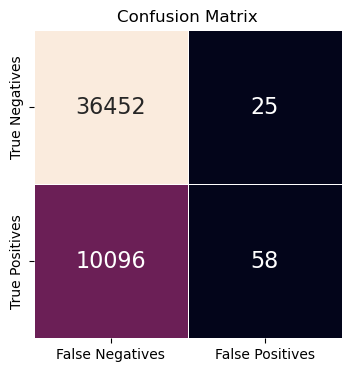



Accuracy:  0.7829555445947974
Precision:  0.6987951807228916
Recall:  0.005712034666141422
F1:  0.0113314447592068
AUC:  0.6494260734390203


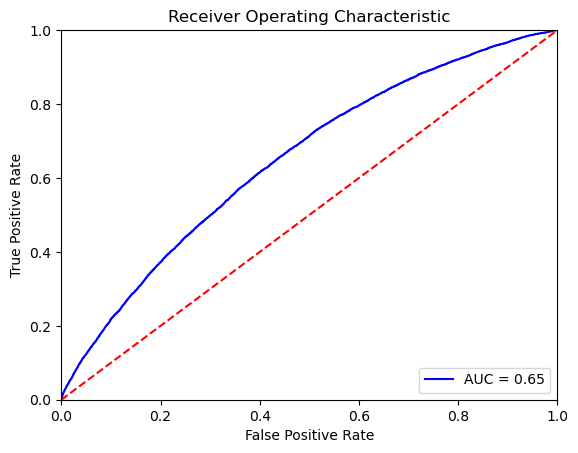

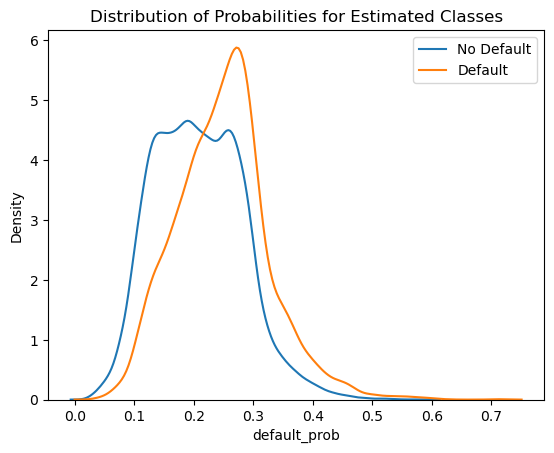

true_class  predicted_class
0           0                  0.999315
            1                  0.000685
1           0                  0.994288
            1                  0.005712
Name: proportion, dtype: float64


In [9]:
# Train RandomForestClassifier without class weights
rfc_model = RandomForestClassifier(n_estimators = 100, max_depth = 15)

rfc_model.fit(x_train, y_train)
eval_model(rfc_model, x_test, y_test)


- This model is the best we have seen so far at separating the two classes, but it is still not managing to identify many defaults
- [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) has a class_weight parameter that can be used to address the problem of class imbalance 
- By setting class_weight to 'balanced', we tell sklearn to automatically adjust the weights for each class so that they have equal influence during model training


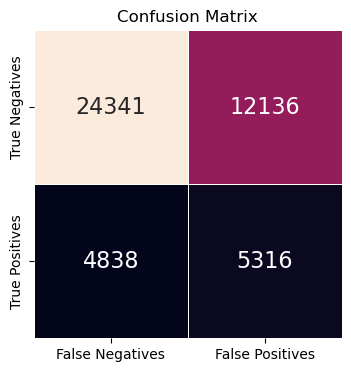



Accuracy:  0.635993223392164
Precision:  0.3046069218427687
Recall:  0.5235375221587552
F1:  0.38513366659421866
AUC:  0.6390743298332743


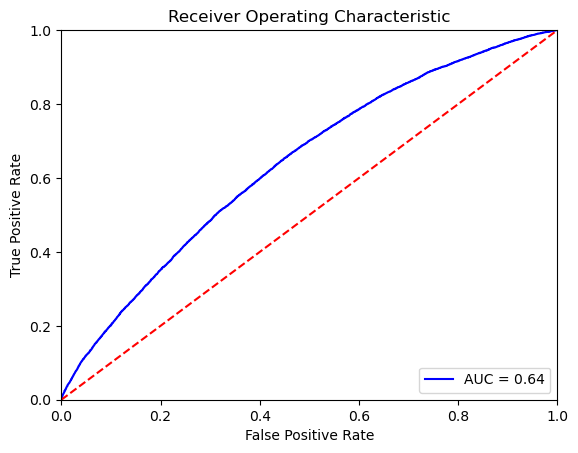

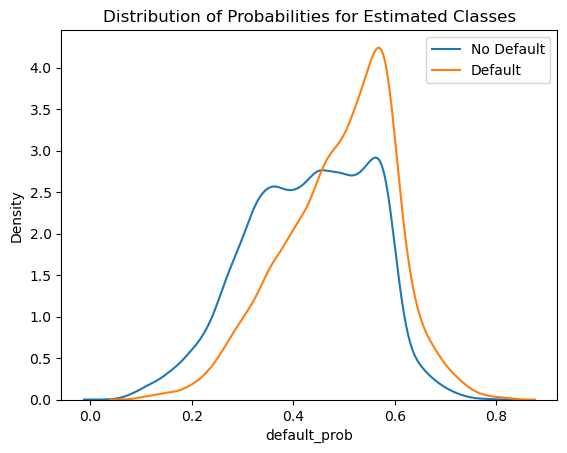

true_class  predicted_class
0           0                  0.667297
            1                  0.332703
1           1                  0.523538
            0                  0.476462
Name: proportion, dtype: float64


In [10]:
# Applying class weights to address imbalance
rfc_model = RandomForestClassifier(n_estimators = 100, max_depth = 15, class_weight='balanced')

rfc_model.fit(x_train, y_train)
eval_model(rfc_model, x_test, y_test)

Some big changes to the model performance

### Accuracy 

- Dropped to ~63%

### Precision 

- 30% down from 66% for the random forest with default class weighting
- Less of the instances we classified as defaults actually were defaults 

### Recall 

- Recall has increased dramatically, from 0.5% to 53%!
- We are now able to correctly identify over half of the loan defaults
- However, we are also incorrectly classifying a large number of non-defaults as defaults

### F1

- The F1 score has also increased dramatically from 0.01 to 38 
- We have a much more balanced model than we did previously

### AUC 

- The area under the roc curve has dropped from 0.65 to 0.64

### Probability Distributions 

- The main peak for Non defaults is inline with the peak for defaults, this makes sense as we know the model is classifying a lot of non-defaults as defaults

Generally, this is a better, more balanced model than the previous ones. However the large numbers of non-defaults predicted as defaults is concerning

### Manual Class Weighting

Passing 'balanced' to the class weight parameter adjusts the class weights so that both classes carry equal influence 

We can also pass a dictionary to class weights to manually set class weightings 

- default (no class weighting) is equivalent to class_weight = {0:0.5, 1:0.5}
- In our case 'balanced' is equivalent to class_weight = {0:0.217, 1:0.783}
- With balanced classes we are incorrectly predicting too many defaults
- Let's tweak the class weights to see if we can amend this

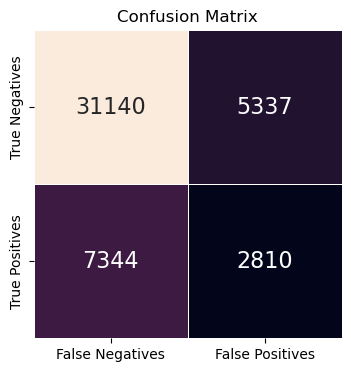



Accuracy:  0.7280564431386846
Precision:  0.3449122376334847
Recall:  0.2767382312389206
F1:  0.30708704442380197
AUC:  0.6431270386050707


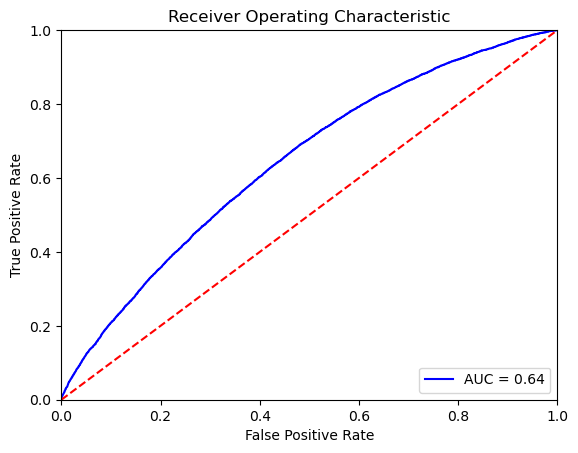

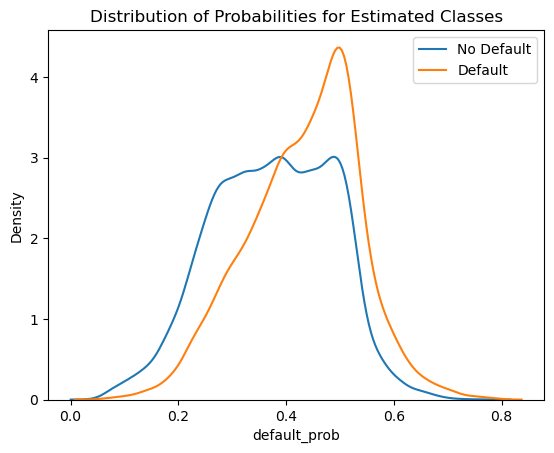

true_class  predicted_class
0           0                  0.853689
            1                  0.146311
1           0                  0.723262
            1                  0.276738
Name: proportion, dtype: float64


In [11]:
# Manual class weighting
weights = {0:0.27, 1:0.73}

rfc_model = RandomForestClassifier(n_estimators = 100, max_depth = 15, class_weight=weights)

rfc_model.fit(x_train, y_train)
eval_model(rfc_model, x_test, y_test)

We have increased the precision and accuracy, but the recall has dropped dramatically!

## Resampling

- We will look at Upsampling, Downsampling and SMOTE (Synthetic Minority Oversampling)

### Upsampling

- Upsampling is the process of resampling the minority class to match the number of instances in the majority
- We only want to resample the training data so let's join the x_train and y_train into one DataFrame
- We create a [copy](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.copy.html) of x_train to avoid the need to recreate our train test split later

In [12]:
# Unsampling 
train_df = x_train.copy()
train_df['LOAN_DEFAULT'] = y_train

- Let's make sure we know what the class distribution looks like 

In [13]:
print(train_df['LOAN_DEFAULT'].value_counts())
print(train_df['LOAN_DEFAULT'].value_counts(normalize=True))

LOAN_DEFAULT
0    146066
1     40457
Name: count, dtype: int64
LOAN_DEFAULT
0    0.783099
1    0.216901
Name: proportion, dtype: float64


- Class distribution is what we expected
- Now we can create subsets for each class value

In [14]:
# Seperate minority and majority classes
train_minority = train_df[train_df['LOAN_DEFAULT'] == 1]
train_majority = train_df[train_df['LOAN_DEFAULT'] == 0]

sklearn provides us with the [resample](https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html) function

we pass it 4 parameters 
- the dataframe which we want to resample
- replace: boolean indicating that we want to resample with replacement
- n_samples: the number of samples to be created 
- random_state: random seed for repeatability

In [15]:
# Unsample the minority class
train_minority_up = resample(train_minority, replace=True,  n_samples=train_majority.shape[0], random_state=123)

We should now have two DataFrames, train_majority and train_minority_up. These should both have the same number of rows
- all the instances in train_majority should be of class 0
- all the instances in train_minority_up should be of class 1

In [16]:
print(train_majority['LOAN_DEFAULT'].value_counts())
print(train_minority_up['LOAN_DEFAULT'].value_counts())

LOAN_DEFAULT
0    146066
Name: count, dtype: int64
LOAN_DEFAULT
1    146066
Name: count, dtype: int64


Now we can use the [concat](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html) function from pandas to join the two dataframes together

In [17]:
# Combine majority and upsampled minority class
train_up_df = pd.concat([train_majority, train_minority_up])

Check the class distribution, it should be 50/50

In [18]:
print(train_up_df['LOAN_DEFAULT'].value_counts())
print(train_up_df['LOAN_DEFAULT'].value_counts(normalize=True))

LOAN_DEFAULT
0    146066
1    146066
Name: count, dtype: int64
LOAN_DEFAULT
0    0.5
1    0.5
Name: proportion, dtype: float64


Finally, we need to separate the target variable from our features and then re-train/evaluate the model

In [19]:
x_train_up = train_up_df.drop(['LOAN_DEFAULT'], axis=1)
y_train_up = train_up_df['LOAN_DEFAULT']

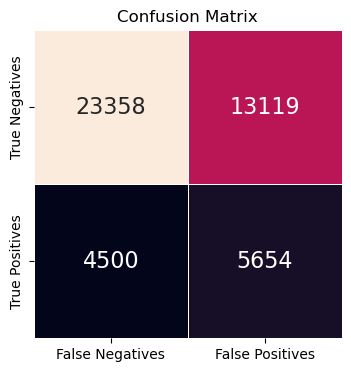



Accuracy:  0.6221612232206043
Precision:  0.30117722260693547
Recall:  0.5568248965924759
F1:  0.3909150620527535
AUC:  0.6431486592075697


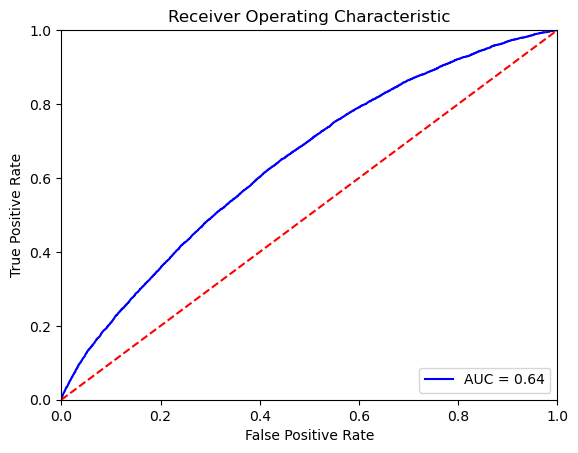

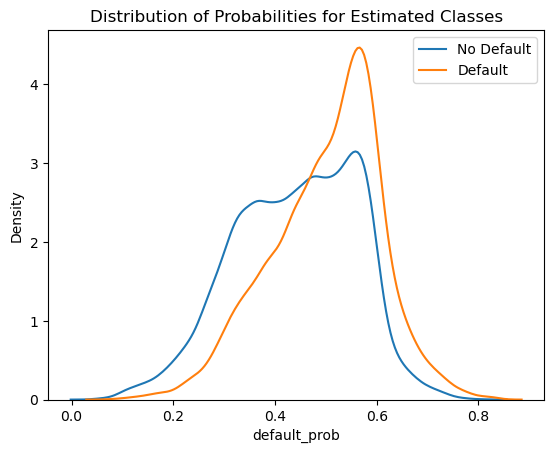

true_class  predicted_class
0           0                  0.640349
            1                  0.359651
1           1                  0.556825
            0                  0.443175
Name: proportion, dtype: float64


In [20]:
# Train RandomForestClassification on upsampled data
rfc_model = RandomForestClassifier(n_estimators = 100, max_depth=15)

rfc_model.fit(x_train_up, y_train_up)
eval_model(rfc_model, x_test, y_test)

Almost identical results to using 'balanced' class weights.

### Downsampling

- Produce balanced training data by downsampling the majority class to match the minority. 

In [21]:
# Downsampling
def balance_sample(x_train, y_train, sample_mode='up'):
    train_df = x_train.copy()
    train_df['LOAN_DEFAULT'] = y_train

    train_minority = train_df[train_df['LOAN_DEFAULT'] == 1]
    train_majority = train_df[train_df['LOAN_DEFAULT'] == 0]

    train_sampled_df = pd.DataFrame()

    if sample_mode == 'down':
        train_majority_down = resample(train_majority, replace=False,  n_samples=train_minority.shape[0], random_state=123)
        train_sampled_df = pd.concat([train_minority, train_majority_down])  
    else:
        train_minority_up = resample(train_minority, replace=True,  n_samples=train_majority.shape[0], random_state=123)
        train_sampled_df = pd.concat([train_majority, train_minority_up])

    x_train_samp = train_sampled_df.drop(['LOAN_DEFAULT'], axis=1)
    y_train_samp = train_sampled_df['LOAN_DEFAULT']

    return x_train_samp, y_train_samp 

In [22]:
# Downsample the training data
x_train_dwn, y_train_dwn = balance_sample(x_train, y_train, sample_mode='down')

print(y_train_dwn.value_counts())
print(y_train_dwn.value_counts(normalize=True))

LOAN_DEFAULT
1    40457
0    40457
Name: count, dtype: int64
LOAN_DEFAULT
1    0.5
0    0.5
Name: proportion, dtype: float64


Lets train and evaluate a RandomForestClassifier using the downsampled training data

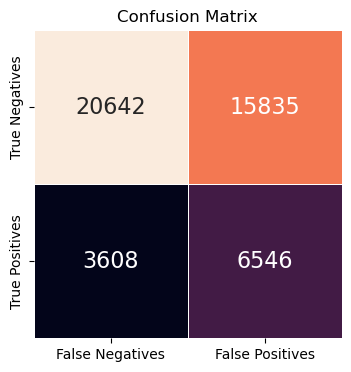



Accuracy:  0.5830456134331239
Precision:  0.2924802287654707
Recall:  0.6446720504234784
F1:  0.40239741816505303
AUC:  0.6476641468783211


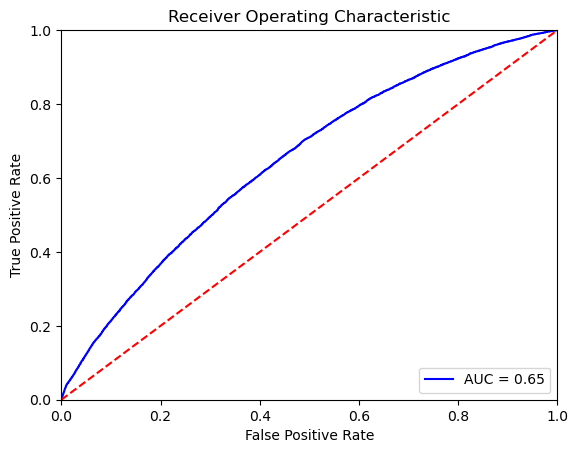

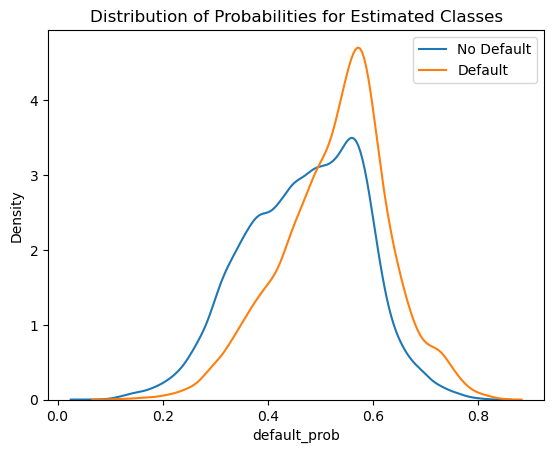

true_class  predicted_class
0           0                  0.565891
            1                  0.434109
1           1                  0.644672
            0                  0.355328
Name: proportion, dtype: float64


In [23]:
# Train RandomForestClassifier on downsampled data
rfc_model = RandomForestClassifier(n_estimators = 100, max_depth = 15)

rfc_model.fit(x_train_dwn, y_train_dwn)
eval_model(rfc_model, x_test, y_test)

### SMOTE

- [SMOTE](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html) upsamples the minority class 
- Rather than simply duplicating data, SMOTE creates new synthetic instances

Let's use SMOTE to create a synthetically upsampled training set

First initialize smote

In [24]:
# SMOTE
smote = SMOTE()

Now we create the training data using fit_resample

In [25]:
x_train_synth, y_train_synth = smote.fit_resample(x_train, y_train)

*NB - If SMOTE takes too long to run or causes a memory error on your machine please uncomment and run the code in the cell below to use the pre-sampled training data we have provided*

In [26]:
# vehicle_train_synth = pd.read_csv('../data/vehicle_train_synth.csv')

# x_train_synth = vehicle_train_synth.drop(['LOAN_DEFAULT'], axis=1)
# y_train_synth = vehicle_train_synth['LOAN_DEFAULT']

Double check the class distribution

In [27]:
print(y_train_synth.value_counts())
print(y_train_synth.value_counts(normalize=True))

LOAN_DEFAULT
1    146066
0    146066
Name: count, dtype: int64
LOAN_DEFAULT
1    0.5
0    0.5
Name: proportion, dtype: float64


Now train and evaluate the model with the SMOTE sampled training data

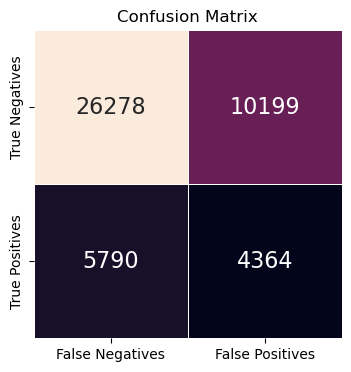



Accuracy:  0.6571165104758637
Precision:  0.29966353086589304
Recall:  0.4297813669489856
F1:  0.35311728769672696
AUC:  0.6246538158967575


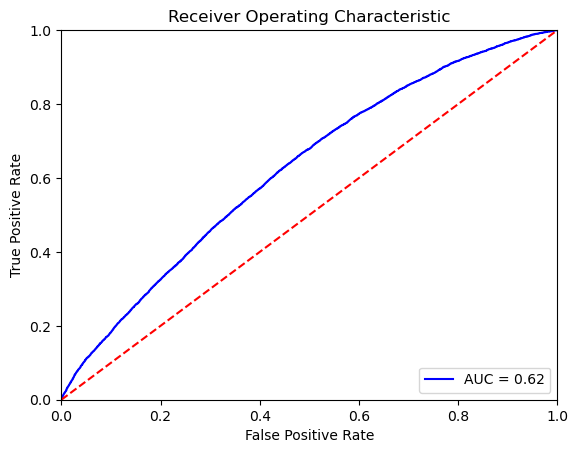

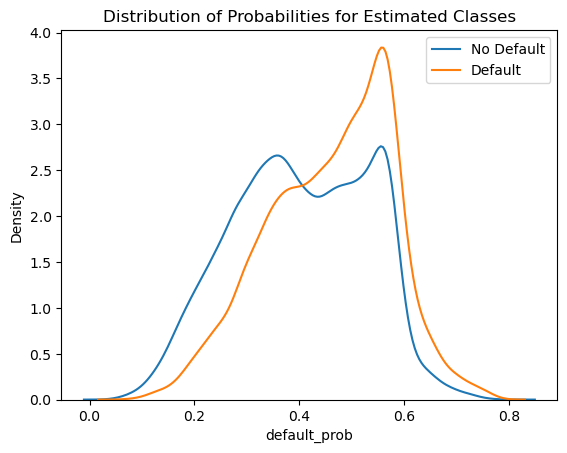

true_class  predicted_class
0           0                  0.720399
            1                  0.279601
1           0                  0.570219
            1                  0.429781
Name: proportion, dtype: float64


In [28]:
# Train RandomForestClassifier on SMOTE-processed data
rfc_model = RandomForestClassifier(n_estimators = 100, max_depth = 15)

rfc_model.fit(x_train_synth, y_train_synth)
eval_model(rfc_model, x_test, y_test)

- Using SMOTE we have trained a model which labels a lot of our test data with the default class
- We again have quite poor precision around 30%
- The AUC is down to ~0.62
- And 57% of our defaulted loans were incorrectly labelled as non-defaults!